In [63]:
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt

Current data is shaped: (1250, 100, 514)


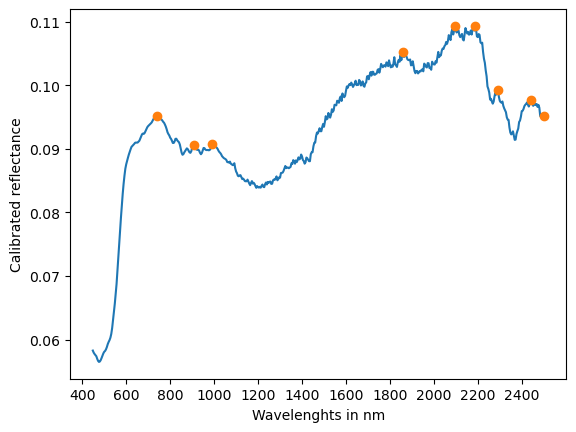

In [64]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 50
curr_y = 54

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')
plt.xticks(np.arange(400,2500, step = 200))

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width = 5)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

In [65]:
from pybaselines import Baseline, utils
from matplotlib import pyplot as plt

class HullRemoval:
    def __init__(self,
                 x_data,
                 y_data,
                invert_data = True,
                do_plots = False):
        self.x_data = x_data
        self.y_data = y_data
        self.baseline_fitter = Baseline(x_data,
                                        check_finite=False)
        self.do_plots = do_plots

        if invert_data:
            self.original_y_data = self.y_data
            self.y_data = 1 - self.y_data
            
    def interpolate_linear(self,
                           spectrum,
                           indices):
        # Create an interpolation function based on the given indices
        interp_func = interp1d(indices,
                               spectrum[indices],
                               fill_value="extrapolate")
        # Apply the interpolation function to the entire range of indices
        lower_hull = interp_func(np.arange(len(spectrum)))
        return lower_hull
    
    def calculate_baseline(self):
        # Get the peaks of the current spectrum
        self.peaks = find_peaks(self.y_data,
                           width = 5)[0]
        # Append the end of the spectrum
        self.peaks = np.append(self.peaks,
                               self.y_data.shape[0]-1)

        # Calculate the baseline
        baseline_inv = self.baseline_fitter.snip(self.y_data,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]
        # Invert the result
        self.curr_baseline = 1 - baseline_inv
        self.baseline_quotient = self.y_data/self.curr_baseline

        if self.do_plots:
            print(self.do_plots)
            plt.plot(self.x_data,
                     self.y_data,
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.curr_baseline,
                     label='Calculated Baseline')
            plt.plot(self.x_data[peaks], self.y_data[peaks], 'o', label='Peaks')
            plt.legend()

            plt.figure()
            plt.plot(self.x_data,
                     self.baseline_quotient,
                     label='Hull Quotient')
            plt.legend()

    def calculate_initial_hull(self):
        # Calculate a hull that attaches each peak linearly
        prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                 self.peaks - self.peaks[0])
        # Concatenate the initial effort of the baseline fitter
        # to the linear fits
        self.concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                      prelim_hull))
        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.y_data, 
                     label='Original Spectrum')
            plt.plot(self.x_data,
                     self.y_data,
                     label='Hybrid Baseline')
            plt.plot(self.x_data[self.peaks],
                     self.y_data[self.peaks],
                     'o',
                     label='Peaks')
            plt.legend()
        
        self.curr_quotient = self.y_data/self.concat_hull
        
        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.curr_quotient,
                     label='Hull Quotient')
            plt.legend()

    def iterate_final_hull(self):
        # Check if the current quotient has any values
        # that exceed 1 (i.e. where we crossed the spectrum
        # with the hull
        n_gt_one = (self.curr_quotient > 1.00).sum()

        # Set a counter so that we don't iterate forever
        count = 0
        
        while n_gt_one > 0:
            curr_index_to_add = self.curr_quotient.argmax()
            # Append this index to the peaks
            self.peaks = np.unique(np.sort(np.append(self.peaks,
                                                     curr_index_to_add)))
            
            
            prelim_hull = self.interpolate_linear(self.y_data[self.peaks[0]:],
                                             self.peaks - self.peaks[0])
            
            self.concat_hull = np.concatenate((self.curr_baseline[0:self.peaks[0]],
                                          prelim_hull))
            # plt.figure()
            # plt.plot(self.x_data,
            #          self.y_data,
            #          label='Original Spectrum')
            # plt.plot(self.x_data,
            #          self.concat_hull,
            #          label='Hybrid Baseline')
            # plt.plot(self.x_data[self.peaks],
            #          self.y_data[self.peaks],
            #          'o',
            #          label='Peaks')
            # plt.legend()
            
            self.curr_quotient = self.y_data/self.concat_hull
     
            n_gt_one = (self.curr_quotient > 1.00).sum()
            
        # Plot the finl result 
        if self.do_plots:
            plt.figure()
            plt.plot(self.x_data,
                     self.curr_quotient,
                     label='Hull Quotient')
            plt.legend()

            count +=1
            print(count)
            if count > 50:
                print('Too many iterations, breaking loop')
                n_gt_one = -1
                

    def do_iterative_hull_removal(self):
        self.calculate_baseline()
        self.calculate_initial_hull()
        self.iterate_final_hull()
        # Return the input original spectrum x and y values
        # the new hull, and the quotient calculated
        return self.x_data, self.y_data, self.concat_hull, self.curr_quotient
    


In [62]:
hull_removal = HullRemoval(wav_array, curr_pixel)

x_data, y_data, concat_hull, hull_quotient = hull_removal.do_iterative_hull_removal()